In [37]:
from pathlib import Path
import math

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.utils import load_img
from skimage.transform import resize
from skimage.io import imread, imshow, imsave

import utils

In [38]:
IMG_WIDTH_ORIGINAL=512
IMG_HEIGHT_ORIGINAL=1024
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 1 # grayscale images
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
NUM_CLASSES = 8 #8 in case just fluids is 4, in case fluids and layers is 8
BATCH_SIZE = 4 # try 4, 8, 12, 16, 32

SRF_CLASS = 6
IRF_CLASS = 7

CLASS_LABELS = (
    "Above ILM",
    "ILM-IPL/INL",
    "IPL/INL-RPE",
    "RPE-BM",
    "Under BM",
    "PED",
    "SRF",
    "IRF",
)

In [39]:
from pathlib import Path
import math

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.utils import load_img
from skimage.transform import resize
from skimage.io import imread, imshow, imsave

In [40]:
OCTID_DATA = Path("./data/intermediate/")
if not OCTID_DATA.exists():
    print("Extracting data...")
    import zipfile
    with zipfile.ZipFile("/datasets/octid/OCTID.zip", 'r') as zip_ref:
        zip_ref.extractall("/tmp")

assert OCTID_DATA.exists()  # If this fails then dataset is not present and something is very wrong!

In [41]:
!ls 

README.md                 crop.ipynb                oct_model_20230125-092315
__pycache__               data                      oct_segmentation.ipynb
aroi_segmentation.ipynb   docs                      segmentation
codes                     model_assesser.ipynb      utils.py


In [42]:
model = keras.models.load_model("./oct_model_20230125-092315/")

In [43]:
normal = OCTID_DATA.glob("normal_cropped/NORMAL*")
armd = OCTID_DATA.glob("armd_cropped/AMRD*")
normal_img_paths = [*normal]
armd_img_paths = [*armd]

print(normal_img_paths.__len__())
print(armd_img_paths.__len__())

206
55


In [44]:

class OCTIDSequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths

    def __len__(self):
        return math.floor(len(self.input_train_paths) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        x = np.zeros((BATCH_SIZE,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            # img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH))
            # out = img.copy()
            # out[390:, :50] = br_noise
            # out = np.expand_dims(out, axis=-1)
            x[j] = img/.255
        return x

        

In [45]:
all_b_r_corners = []
for idx, image in enumerate(normal_img_paths):
    i = np.array(load_img(image, color_mode="grayscale"))[378:, -50:]
    all_b_r_corners.append(i)

In [46]:
img = load_img(armd_img_paths[0], target_size=(512, 256), color_mode="grayscale")
img = np.array(img)


In [47]:
armd_seq = OCTIDSequence(BATCH_SIZE, IMG_SIZE, armd_img_paths)
normal_seq = OCTIDSequence(BATCH_SIZE, IMG_SIZE, normal_img_paths)

In [48]:
predictions = model.predict(armd_seq)
predictions = np.argmax(predictions, axis=-1)

2023-02-07 16:31:47.929332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 4s 261ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


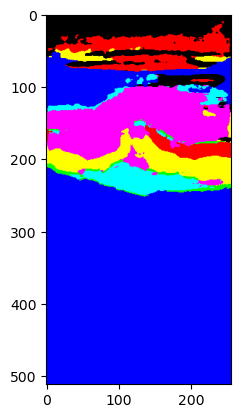

In [49]:
plt.imshow(utils.num_to_colors(predictions[20], IMG_HEIGHT, IMG_WIDTH))

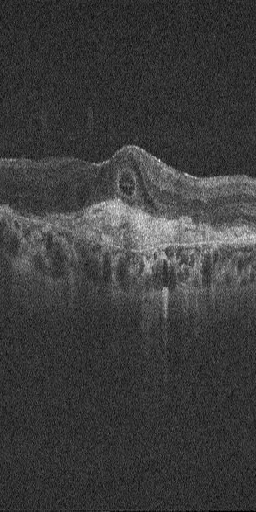

In [50]:
load_img(armd_img_paths[20], target_size=(512, 256))

In [51]:
for idx, image in enumerate(predictions):
    # colour_image = utils.num_to_colors(image, IMG_HEIGHT, IMG_WIDTH)
    # extract name of file from path
    name = str(armd_img_paths[idx]).split("/")[-1].split(".")[0]
    imsave(f"./segmentation/octid_predictions/armd/{name}.png", image.astype(np.uint8))

predictions = model.predict(normal_seq)
predictions = np.argmax(predictions, axis=-1)

for idx, image in enumerate(predictions):
    # colour_image = utils.num_to_colors(image, IMG_HEIGHT, IMG_WIDTH)
    # extract name of file from path
    name = str(normal_img_paths[idx]).split("/")[-1].split(".")[0]
    imsave(f"./segmentation/octid_predictions/normal/{name}.png", image.astype(np.uint8))

/var/folders/3p/cmcfy1q16ts0p3tb67072b6c0000gn/T/ipykernel_22543/2485381802.py:5: UserWarning: ./segmentation/octid_predictions/armd/AMRD17.png is a low contrast image
  imsave(f"./segmentation/octid_predictions/armd/{name}.png", image.astype(np.uint8))
/var/folders/3p/cmcfy1q16ts0p3tb67072b6c0000gn/T/ipykernel_22543/2485381802.py:5: UserWarning: ./segmentation/octid_predictions/armd/AMRD16.png is a low contrast image
  imsave(f"./segmentation/octid_predictions/armd/{name}.png", image.astype(np.uint8))
/var/folders/3p/cmcfy1q16ts0p3tb67072b6c0000gn/T/ipykernel_22543/2485381802.py:5: UserWarning: ./segmentation/octid_predictions/armd/AMRD28.png is a low contrast image
  imsave(f"./segmentation/octid_predictions/armd/{name}.png", image.astype(np.uint8))
/var/folders/3p/cmcfy1q16ts0p3tb67072b6c0000gn/T/ipykernel_22543/2485381802.py:5: UserWarning: ./segmentation/octid_predictions/armd/AMRD14.png is a low contrast image
  imsave(f"./segmentation/octid_predictions/armd/{name}.png", image.as

51/51 [==============================] - 13s 265ms/step


/var/folders/3p/cmcfy1q16ts0p3tb67072b6c0000gn/T/ipykernel_22543/2485381802.py:14: UserWarning: ./segmentation/octid_predictions/normal/NORMAL148.png is a low contrast image
  imsave(f"./segmentation/octid_predictions/normal/{name}.png", image.astype(np.uint8))
/var/folders/3p/cmcfy1q16ts0p3tb67072b6c0000gn/T/ipykernel_22543/2485381802.py:14: UserWarning: ./segmentation/octid_predictions/normal/NORMAL160.png is a low contrast image
  imsave(f"./segmentation/octid_predictions/normal/{name}.png", image.astype(np.uint8))
/var/folders/3p/cmcfy1q16ts0p3tb67072b6c0000gn/T/ipykernel_22543/2485381802.py:14: UserWarning: ./segmentation/octid_predictions/normal/NORMAL174.png is a low contrast image
  imsave(f"./segmentation/octid_predictions/normal/{name}.png", image.astype(np.uint8))
/var/folders/3p/cmcfy1q16ts0p3tb67072b6c0000gn/T/ipykernel_22543/2485381802.py:14: UserWarning: ./segmentation/octid_predictions/normal/NORMAL88.png is a low contrast image
  imsave(f"./segmentation/octid_predictio